# Task 1 Bag of Words and simple Features
## 1.1 
Create a baseline model using a bag-of-words approach and a linear model.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

%matplotlib inline

In [2]:
train = pd.read_csv('reddit_200k_train.csv', encoding='latin1').fillna(' ')
test = pd.read_csv('reddit_200k_test.csv', encoding='latin1').fillna(' ')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167529 entries, 0 to 167528
Data columns (total 8 columns):
Unnamed: 0       167529 non-null int64
body             167529 non-null object
score.x          167529 non-null int64
parent_id.x      167529 non-null object
id               167529 non-null object
created_utc.x    167529 non-null int64
retrieved_on     167529 non-null int64
REMOVED          167529 non-null bool
dtypes: bool(1), int64(4), object(3)
memory usage: 9.1+ MB


In [4]:
train.describe()

,Unnamed: 0,score.x,created_utc.x,retrieved_on
count,167529.000000,167529.000000,1.675290e+05,1.675290e+05
mean,83765.000000,41.251676,1.511525e+09,1.513583e+09
std,48361.600961,356.321130,1.604385e+07,1.657645e+07
min,1.000000,-190.000000,1.483229e+09,1.485680e+09
25%,41883.000000,0.000000,1.497476e+09,1.499352e+09
50%,83765.000000,2.000000,1.511533e+09,1.512960e+09
75%,125647.000000,7.000000,1.525543e+09,1.527118e+09
max,167529.000000,32740.000000,1.538350e+09,1.539713e+09


Note that since we have an **imbalanced** setting for the training set, we will use ROC-AUC as performance metric.

In [5]:
print('Train class balance:', np.bincount(train['REMOVED']))
print('Test class balance:', np.bincount(test['REMOVED']))

Train class balance: [102791  64738]
Test class balance: [34565 21278]


**Objective**: what features are most predictive of popular comments getting removed?
  - `X`: comments
  - `y`: whether comments are removed. 
      - We converted the boolean variable to binary so that `True` = 1 and `False` = 0

In [6]:
X_train = train['body']
y_train = np.array(train['REMOVED'].astype(int)).reshape(-1, 1)
X_test = test['body']
y_test = np.array(test['REMOVED'].astype(int)).reshape(-1, 1)

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
# from sklearn.model_selection import GridSearchCV
from dabl.search import GridSuccessiveHalving
# from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

def fit_model(X_train, y_train, method=None):
    """
    :param method: (for task 1.2) method to tune 
    ('n-grams','characters', 'tf-idf', 'combined')
    """
    
    if method is not None:
        pipe = make_pipeline(TfidfVectorizer(stop_words='english', 
                                             min_df=4,
                                             max_features=50000,
                                             use_idf=False), 
                             LogisticRegression(),
                             memory='cache_folder')
        if method == 'tf_idf':
            param_grid = {'logisticregression__C': [0.01, 1, 10, 100],
                          'tfidfvectorizer__use_idf': (True, False),
                          'tfidfvectorizer__sublinear_tf': (True, False)}
            pipe = make_pipeline(TfidfVectorizer(stop_words='english', 
                                                 min_df=4,
                                                 max_features=50000),
                                 LogisticRegression(),
                                 memory='cache_folder')             
        if method == 'characters':
            param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10],
                          'tfidfvectorizer__analyzer': ['word', 'char', 'char_wb']}
        if method == 'n_grams':
            param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10],
                          'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (2, 3)]}
        if method == "combined":
            param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10],
                          'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
                          'tfidfvectorizer__sublinear_tf': (True, False)}   
    else:
        param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10]}
        pipe = make_pipeline(TfidfVectorizer(stop_words='english', 
                                             norm=None,
                                             min_df=4,
                                             max_features=50000,
                                             use_idf=False), 
                             LogisticRegression(),
                             memory='cache_folder')
    
    grid = GridSuccessiveHalving(pipe, param_grid, scoring='roc_auc', n_jobs=-1, cv=5)
    grid.fit(X_train, y_train)
    
    print('Best parameter(s): ', grid.best_params_)
    print('Train ROC-AUC: ', grid.best_score_)
    
#     Evaluate on test set
#     y_pred = grid.predict_proba(X_test)[:, 1]
#     test_score = roc_auc_score(y_test, y_pred)
#     print('Test ROC-AUC: ', test_score)
    
    return grid

In [39]:
grid_base = fit_model(X_train, y_train)

Best parameter(s):  {'logisticregression__C': 0.1}
Train ROC-AUC:  0.753314367159694


- The baseline BoW model
    - Logistic Regression model (C = 0.1)
    - Preprocessing 
        - Restricts stop words and infrequent words.
            - stop_words='english', min_df=4, max_features=50000
        - No normalization
    - ROC-AUC = 0.753314367159694
- Based on the best model, we display the top 30 largest negative/positive coefficients to show feature importance. 

In [40]:
%matplotlib inline
def plot_coef(coef, feature_names, top_features=30, title=None):
    """
    :params coef: Coefficients to plot.
    :params feature_names: Feature names.
    :params top_features: Top n features to plot; default=30.
    """
    top_pos_coef = np.argsort(coef)[-top_features:]
    top_neg_coef = np.argsort(coef)[:top_features]
    top_coef = np.hstack([top_neg_coef, top_pos_coef])
    feature_names = np.array(feature_names)
    
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coef]]     
    _ = plt.figure(figsize=(20, 8)) 
    _ = plt.bar(np.arange(2 * top_features), coef[top_coef], color=colors) 
    _ = plt.xticks(np.arange(1, 1 + 2 * top_features), 
                   feature_names[top_coef], rotation=60, ha='right')
    _ = plt.xlabel('Features')
    _ = plt.ylabel('Coefficients')
    _ = plt.title(title)

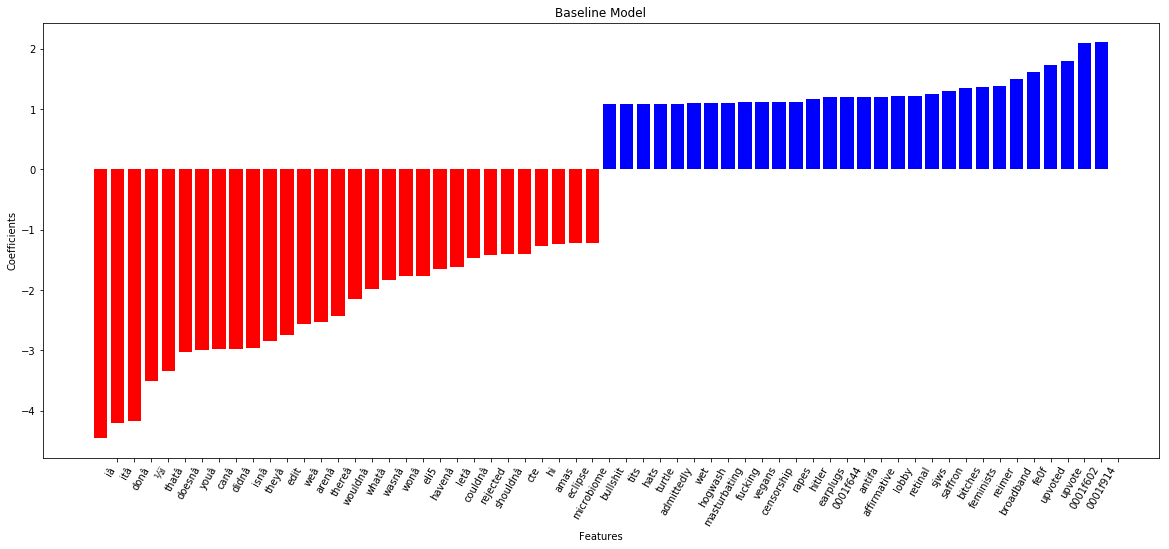

In [43]:
# Collect all feature names
tfidf_base = TfidfVectorizer(stop_words='english', 
                        min_df=4, 
                        norm=None,
                        max_features=50000, 
                        use_idf=False)
tfidf_base.fit_transform(X_train)
feature_names_base = tfidf_base.get_feature_names()

model_base = make_pipeline(tfidf_base, LogisticRegression(C=1), memory='cache_folder')
model_base.fit(X_train, y_train)

# Collect coefficients
coef_base = model_base.named_steps['logisticregression'].coef_[0]

plot_coef(coef_base, feature_names_base, title='Baseline Model')

- Initial observations
    - The following comments are more likely to be deleted:
        - Meaningless and repetitive comments: e.g., `upvoted`
        - Socially sensitive comments: e.g., `rapes`
        - Socially progressive comments: e.g., `feminists` and `sjws`
        - Politically sensitive comments: e.g., `hitler`
        - Comments involving swear words: e.g., `fucking`, `bitches` and `hogwash`
    - On the other hand, the comments that are less likely to be removed only contain auxiliaries.
    - Additional remarks
        - Some Unicode characters are distorted when encoding. 
            - Most tokenized features with positive coefficients contain the special character"Â", which represents the non-breaking spaces from the HTML template (the &nbsp;s). 
            - Some features with large negative coefficients, such as `0001f914`, `0001f602` and `fe0f`.

## 1.2 
Try using n-grams, characters, tf-idf rescaling and possibly other ways to tune the BoW model. Be aware that you might need to adjust the (regularization of the) linear model for different feature sets.

### tf-idf

In [9]:
grid_tfidf = fit_model(X_train, y_train, method='tf_idf')

Best parameter(s):  {'logisticregression__C': 1, 'tfidfvectorizer__sublinear_tf': True, 'tfidfvectorizer__use_idf': False}
Train ROC-AUC:  0.7644694415676356


### Characters

In [10]:
grid_char = fit_model(X_train, y_train, method='characters')

Best parameter(s):  {'logisticregression__C': 1, 'tfidfvectorizer__analyzer': 'word'}
Train ROC-AUC:  0.7632738828461448


### N-grams

In [11]:
grid_ngrams = fit_model(X_train, y_train, method='n_grams')

Best parameter(s):  {'logisticregression__C': 1, 'tfidfvectorizer__ngram_range': (1, 2)}
Train ROC-AUC:  0.7664128822798487


### Combined

In [14]:
grid_combined = fit_model(X_train, y_train, method='combined')

Best parameter(s):  {'logisticregression__C': 1, 'tfidfvectorizer__ngram_range': (1, 2), 'tfidfvectorizer__sublinear_tf': True}
Train ROC-AUC:  0.7669171468063567


### Best model and feature selection

- The best model has the following parameters with ROC-AUC = 0.7669171468063567:
    - C = 1
    - ngram_range=(1, 2): 1-2 gram vocabulary size
    - sublinear_tf=True: logarithmic term frequency 
- Based on the best model, we display the top 30 largest negative/positive coefficients to show feature importance. 

In [22]:
# Collect all feature names
tfidf = TfidfVectorizer(stop_words='english', 
                        min_df=4, 
                        max_features=50000, 
                        use_idf=False,
                        sublinear_tf=True,
                        ngram_range=(1, 2))
tfidf.fit_transform(X_train)
feature_names = tfidf.get_feature_names()

# Fit the best model
model = make_pipeline(tfidf, LogisticRegression(C=1), memory='cache_folder')
model.fit(X_train, y_train)

# Collect coefficients
coef = model.named_steps['logisticregression'].coef_[0]

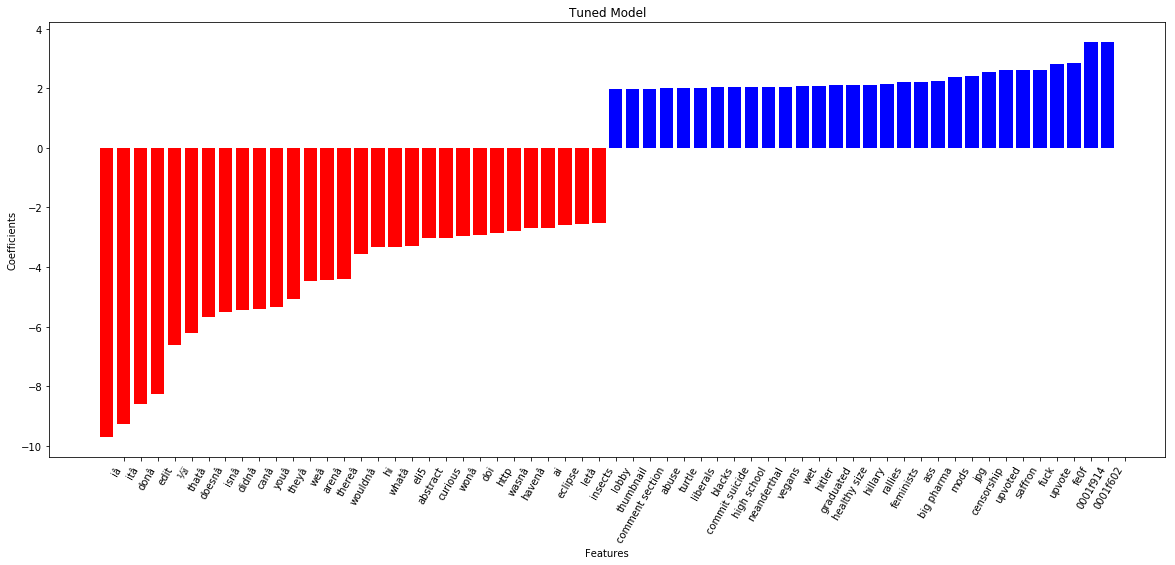

In [64]:
plot_coef(coef, feature_names, title='Tuned Model')

- Observations
    - The following comments are more likely to be deleted:
        - Meaningless and repetitive comments: e.g., `upvote` and `upvoted` 
        - Socially sensitive comments: e.g., `commit suicide`
        - Socially progressive comments: e.g., `feminists`
        - Politically sensitive comments: e.g., `liberals`, `hitler`, and `hillary`
        - Racially sensitive comments (not in baseline model): e.g., `blacks` and `neanderthal`
        - Comments involving swear words such as `fuck` and `ass`
        - Comments with `jpg` attachments (not in baseline model)
    - On the other hand, the comments that are less likely to be removed contain 
        - Auxiliaries 
        - Neutral or positive words (not in baseline model): e.g., `abstract`, `curious`, `insects` and `hobbies`
    - Additional remarks
        - Like baseline model, some Unicode characters are distorted when encoding. 

## 1.3 
Explore other features you can derive from the text, such as html, length, punctuation, capitalization or other features you deem important from exploring the dataset.

In [57]:
from scipy.sparse import hstack
from scipy.sparse import csr_matrix

def fit_model_derived(X_train, y_train, derived=None):
    """
    :param derived: derived feature obtained using 
    'punctuation', 'capital', 'length_doc', 'url'
    """
    
    tfidf = TfidfVectorizer(stop_words='english', min_df=4, max_features=50000, 
                            ngram_range=(1, 2), use_idf=False, sublinear_tf=True)
    tfidf.fit(X_train)
    X_train_trans = tfidf.transform(X_train) 
    
    if derived != 'combined':
        if derived == 'punctuation':
            X_train_derived = X_train.str.findall(r'[!?*]').str.len()   
        if derived == 'capital':
            X_train_derived = X_train.str.findall(r'[A-Z]').str.len()        
        if derived == 'length_doc':  
            X_train_derived = X_train.str.len() 
        if derived == 'url':
            url_pattern = r'/^(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)*\/?$/'
            X_train_derived = X_train.str.contains(url_pattern) 
    
        # Need to take the transpose as we only have 1D-array.
        X_train_new = hstack([X_train_trans, csr_matrix(X_train_derived).T]) 
        
    else:
        X_train_punc = X_train.str.findall(r'[!?*]').str.len()
        X_train_cap = X_train.str.findall(r'[A-Z]').str.len() 
        url_pattern = r'/^(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)*\/?$/'
        # Change dtype to int as csr_matrix can only apply to one dtype.
        X_train_url = X_train.str.contains(url_pattern).astype(int) 
        
        X_train_derived = pd.concat([X_train_punc, X_train_cap, X_train_url], 
                                    ignore_index=True, axis=1)
    
        X_train_new = hstack([X_train_trans, csr_matrix(X_train_derived)]) 
        
    param_grid = {'C': [0.1, 1, 10, 100]}
    grid = GridSuccessiveHalving(LogisticRegression(), param_grid, 
                                 scoring='roc_auc', n_jobs=-1, cv=5)
    grid.fit(X_train_new, y_train)
    
    print('Best parameter(s): ', grid.best_params_)
    print('ROC-AUC: ', grid.best_score_)
    
    return grid

### Punctuation frequency
- Counts of '!', '?', '*'

In [32]:
grid_punc, X_train_punc = fit_model_derived(X_train, y_train, derived='punctuation')

Best parameter(s):  {'C': 1}
ROC-AUC:  0.7674636744586373


### Capital frequency
- Counts of capital letters

In [33]:
grid_cap = fit_model_derived(X_train, y_train, derived='capital')

Best parameter(s):  {'C': 1}
ROC-AUC:  0.7673734642750238


### Length of document

In [34]:
grid_length_doc = fit_model_derived(X_train, y_train, derived='length_doc')

Best parameter(s):  {'C': 10}
ROC-AUC:  0.758755819386639


### Presence of url
- Whether the document contains url. 
- Boolean variable.

In [35]:
grid_url = fit_model_derived(X_train, y_train, derived='url')

Best parameter(s):  {'C': 1}
ROC-AUC:  0.7667499564818945


### Combined

In [36]:
grid_combined_der = fit_model_derived(X_train, y_train, derived='combined')

Best parameter(s):  {'C': 1}
ROC-AUC:  0.7678179485333205


### Best model and feature selection
- The best model has the following parameters with ROC-AUC = 0.7678179485333205:
    - C = 1
    - ngram_range=(1, 2): 1-2 gram vocabulary size
    - sublinear_tf=True: logarithmic term frequency
- The derived features added to the original feature are:
    - Punctuation frequency
    - Capital frequency
    - Presence of url
- Based on the best model, we display the top 30 largest negative/positive coefficients to show feature importance. 

In [60]:
# Collect all feature names
feature_names_der = np.concatenate((feature_names, 
                                    ['punc_freq', 'cap_freq', 'include_url']), axis=None)

# Collect coefficients
coef_der = grid_combined_der.best_estimator_.coef_[0]

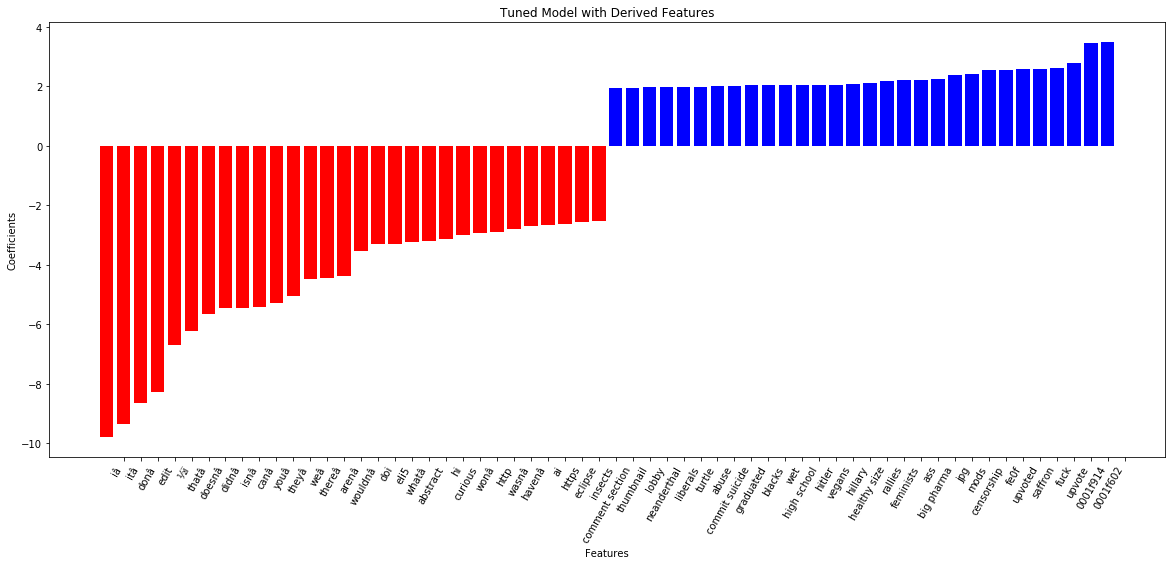

In [63]:
plot_coef(coef_der, feature_names_der, title='Tuned Model with Derived Features')

- Remark
    - The pattern for comment removal does not change too much from the best model in part 1.2. The three derived features do not show in the above plot, so that they are not so important for prediction. Indeed, the two models only vary a little in ROC-AUC score.

# Task 2 Word Vectors
Use a pretrained word-embedding (word2vec, glove or fasttext) instead of the bag-of-words model. Does this improve classification?

In [66]:
import gensim
from gensim import corpora, models

w = models.KeyedVectors.load_word2vec_format(
    'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz', 
    binary = True)

In [74]:
from sklearn.feature_extraction.text import CountVectorizer

vect_w2v = CountVectorizer(vocabulary = w.index2word)
vect_w2v.fit(X_train)
docs = vect_w2v.inverse_transform(vect_w2v.transform(X_train))

In [75]:
X_train_w2v = []

for i in docs:
    if len(i) == 0: X_train_w2v.append(np.zeros(300))
    else:
        X_train_w2v.append(np.mean(w[i], axis = 0))
        
X_train_w2v = np.asarray(X_train_w2v)
X_train_w2v.shape

(167529, 300)

In [70]:
docs_test = vect_w2v.inverse_transform(vect_w2v.transform(X_test))

X_test_w2v = []
for i in docs_test:
    if len(i) == 0: X_test_w2v.append(np.zeros(300))
    else:
        X_test_w2v.append(np.mean(w[i], axis = 0))

In [71]:
param_w2v = {'C': [0.1, 1, 10, 100]}
grid_w2v = GridSuccessiveHalving(LogisticRegression(), param_w2v, 
                                 scoring='roc_auc', n_jobs=-1, cv=5)
grid_w2v.fit(X_train_w2v, y_train)

print('Best parameter: ', grid_w2v.best_params_)
print('ROC-AUC: ', grid_w2v.best_score_)

Best parameter:  {'C': 1}
ROC-AUC:  0.7281880909523222


- Remark
    - We can see that the model does NOT improve. This may due to the way we encode the dataset, which generates a lot of special characters along with the original word. Therefore, there might be mismatches with the vocabulary library, leading to a worse score.
    - Nevertheless, we should note that theoretically, we shall expect better performance by Word2vec, as it captures semantics of words and synonymous words as skip-gram model. Using cosine distance, it preserves text similarities better than bag of words approach.